### Collaboration's notice


1. Improvements compared with V0.1:
   - Break the function ``egm_factory`` into two functions ``optimal_c`` and ``K``.
   - Convert it into ``MyST-md`` format by ``jupytext``.
   - Adjust the coefficient of $P$ and $\sigma$_vec and $\mu$-vec.
   - Converging time is shorter.
   - Add assumption testings.

2. Fault:
   - It still takes too much time to converge.

3. Solution:
   - Adjust the coefficients of $P$ and $\sigma$_vec and $\mu$-vec.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from interpolation import interp
from numba import jit, njit, jitclass, prange, float64
from quantecon.optimize.root_finding import brentq

%matplotlib inline

In [2]:
ifp_data = [
    ('γ', float64),              # Utility parameter 
    ('P', float64[:, :]),        # Transition probs for z_t
    ('σ_vec', float64[:]),       # Shock scale parameters for R_t, β_t, Y
    ('μ_vec', float64[:]),       
    ('a_grid', float64[:]),      # Grid over asset values (array)
    ('s_grid', float64[:]),
    ('ε_draws', float64[:]),
    ('η_draws', float64[:]),     # Draws of innovation η for MC (array)
    ('ζ_draws', float64[:])      # Draws of innovation ζ for MC (array)
]

In [3]:
@jitclass(ifp_data)
class IFP:
    """
    A class that stores primitives for the income fluctuation 
    problem. 
    """
    def __init__(self,
                 γ=2.5,                        
                 P=np.array([(0.8, 0.2), 
                             (0.7, 0.3)]),
                 σ_vec=np.array((0.0, -3.26)),
                 μ_vec=np.array((0.0, 0.025)),
                 shock_draw_size=400,
                 grid_max=10,
                 grid_size=20):
        
        np.random.seed(1234)  # arbitrary seed

        self.γ = γ
        self.P, self.σ_vec, self.μ_vec = P, σ_vec, μ_vec
        self.ε_draws = np.random.randn(shock_draw_size)
        self.η_draws = np.random.randn(shock_draw_size)
        self.ζ_draws = np.random.randn(shock_draw_size)
        self.a_grid = np.linspace(0, grid_max, grid_size)
        self.s_grid = np.copy(self.a_grid)
        
    # Marginal utility    
    def u_prime(self, c):
        return c ** (-self.γ)
    
    # Inverse utility
    def u_prime_inv(self, du):
        return du ** (-1 / self.γ)
    
    def β(self, z, ε):
        return np.exp(self.σ_vec[z] * ε + self.μ_vec[z])
    
    def R(self, z, ζ):
        return np.exp(self.σ_vec[z] * ζ + self.μ_vec[z])
    
    def Y(self, z, η):
        return np.exp(self.σ_vec[z] * η + self.μ_vec[z])

In [4]:
@njit
def optimal_c(s, z, σ_vec, ifp):
    
    u_prime, u_prime_inv = ifp.u_prime, ifp.u_prime_inv
    a_grid, s_grid = ifp.a_grid, ifp.s_grid
    η_draws, ζ_draws, ε_draws = ifp.η_draws, ifp.ζ_draws, ifp.ε_draws
    β, R, Y, P = ifp.β, ifp.R, ifp.Y, ifp.P
    
    
    c = lambda a, z: interp(a_grid, σ_vec[:, z], a)
        
    Ez = 0.0
    for z_hat in (0, 1):
        for η in η_draws:
            for ζ in ζ_draws:
                for ε in ε_draws:
                    β_hat = β(z_hat, ε)
                    R_hat = R(z_hat, ζ)
                    Y_hat = Y(z_hat, η)
                    Ez += β_hat * R_hat * u_prime(c(R_hat * s + Y_hat, z_hat)) * P[z, z_hat]
                
    Ez = Ez / (len(η_draws) * len(ζ_draws) * len(ε_draws))
    return u_prime_inv(Ez)
    

In [5]:
@njit
def K(c, ifp):
    
    a_grid, s_grid = ifp.a_grid, ifp.s_grid
    
    c_new = np.empty_like(c)
    for z in (0, 1):
        for i in range(len(s_grid)):
            s = s_grid[i]
            
            c_new[i, z] = optimal_c(s, z, c, ifp)
            
        a_new = c_new[:, z] + s_grid
        c_new[:, z] = interp(a_new, c_new[:, z], a_grid)
        
        c_new[:, z] = np.minimum(c_new[:, z], a_grid)
        
    return c_new

In [6]:
def solve_model(ifp,
                K,
                tol=1e-2,
                max_iter=1e3,
                verbose=True,
                print_skip=4):

    """
    Solves for the optimal policy using operator K

    * ifp is an instance of ConsumerProblem
    * K is an operator that updates consumption policy
    """

    # Initial guess of c_vec = consume all assets
    n = len(ifp.a_grid)
    c = np.empty((n, 2))
    for z in 0, 1:
        c[:, z] = ifp.a_grid

    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        c_new = K(c, ifp)

        error = np.max(np.abs(c - c_new))
        i += 1

        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")

        c[:, :] = c_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return c

In [7]:
ifp = IFP()
c = solve_model(ifp, K)


Converged in 3 iterations.


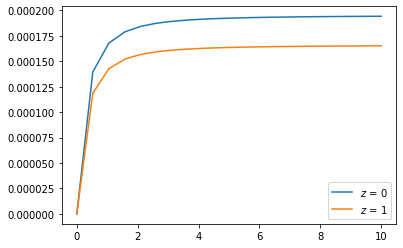

In [8]:
for z in [0, 1]:
    plt.plot(ifp.a_grid, c[:, z], label=f"$z$ = {z}")

plt.legend()
plt.show()

## Testing the assumptions

In [9]:
@njit
def growth_condition_beta(ifp):
    u_prime, u_prime_inv = ifp.u_prime, ifp.u_prime_inv
    a_grid, s_grid = ifp.a_grid, ifp.s_grid
    η_draws, ζ_draws, ε_draws = ifp.η_draws, ifp.ζ_draws, ifp.ε_draws
    n = len(ε_draws)
    β, R, Y, P = ifp.β, ifp.R, ifp.Y, ifp.P
    
    β_prod = np.ones(n)
    for z_hat in (0, 1):
        for t in range(n):
            β_prod[t+1] = β(z_hat, ε_draws[t+1]) * β_prod[t]
    return β_prod[n] ** (1/n) 

In [10]:
growth_condition_beta(ifp)

0.8459144457314439

In [11]:
@njit
def growth_condition_betaR(ifp):
    u_prime, u_prime_inv = ifp.u_prime, ifp.u_prime_inv
    a_grid, s_grid = ifp.a_grid, ifp.s_grid
    η_draws, ζ_draws, ε_draws = ifp.η_draws, ifp.ζ_draws, ifp.ε_draws
    n = len(ε_draws)
    β, R, Y, P = ifp.β, ifp.R, ifp.Y, ifp.P
    
    βR_prod = np.ones(n)
    for z_hat in (0, 1):
        for t in range(n):
            βR_prod[t+1] = β(z_hat, ε_draws[t+1]) * R(z_hat, ζ_draws[t+1]) * βR_prod[t]
    return βR_prod[n] ** (1/n) 

In [12]:
growth_condition_betaR(ifp)

0.9794039733201451